In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Logging in Python,174.885869,6.995435,25
Finance Junk,396.604196,132.201399,3
SharePoint,663.467757,39.027515,17
Azure Functions,700.999024,63.727184,11
Azure AI Search,776.048808,55.432058,14
Lost in a Good Book,1146.752240,57.337612,20
Azure Functions + PP365,1155.298984,24.580829,47
PP365,1194.483799,132.720422,9
Taxes,1228.998759,122.899876,10
Network Mapping,1476.928079,70.329909,21


# Histogram

51182.87


<Axes: >

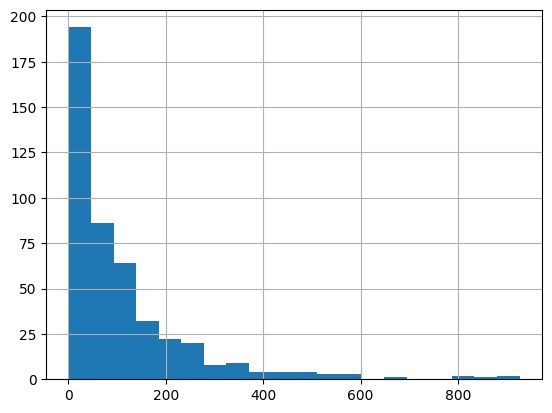

In [23]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [24]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

In [25]:
65e3/1000*40/60

43.333333333333336

# Age Sort

In [26]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [27]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [28]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [29]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [30]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [31]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [32]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [33]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [34]:
n = 6
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 459


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
28,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,-926.435332,232.999712,-926.435332,4426.994529,0.946348,0,0
29,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,-921.172573,232.999712,-926.435332,4426.994529,0.946348,1,0
31,Home Network Project,Front: What is Snort and how is it used in net...,683e252e6cd1d5d4c6a922595ea870c2,-548.345359,232.999712,-926.435332,4426.994529,0.946348,2,0
100,Home Network Project,Front: How does Pi-hole utilize DNS Sinkholing...,cd76cc64a6d457c85a16492c91520a16,-404.591170,232.999712,-926.435332,4426.994529,0.946348,3,0
101,Home Network Project,Front: Explain the difference between a Docker...,cae03ba26ac3afa5df9d5bb453b94dfd,-344.450794,232.999712,-926.435332,4426.994529,0.946348,4,0
102,Home Network Project,Front: What is Network Latency and how can it ...,bd0bb233271b734d83628f3d11673db1,-211.444238,232.999712,-926.435332,4426.994529,0.946348,5,0
49,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,-875.394172,106.729969,-875.394172,2454.789281,0.152221,0,0
50,Open Source/GitHub,"PEP 8\n\nPython Enhancement Proposal 8, the st...",b320da9e64259e5f42a9c7e954f15c67,-156.708659,106.729969,-875.394172,2454.789281,0.152221,1,0
51,Open Source/GitHub,GitHub Actions\n\nA feature on GitHub that all...,5281dc641160e7670129700c5b04176a,-141.615449,106.729969,-875.394172,2454.789281,0.152221,2,0
121,Open Source/GitHub,Good First Issue\n\nA label for beginner-frien...,ee4aff4c065b819d4ed6d2b8c3820ee9,-125.876346,106.729969,-875.394172,2454.789281,0.152221,3,0


## Age Mean

In [35]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [36]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [37]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
28,Home Network Project,Front: What is Fail2Ban and how does it protec...,d7fc83e3380f6d95ec44141a17d86066,-926.435332,232.999712,-926.435332,4426.994529,0.946348,0,0
29,Home Network Project,Front: What is Rate Limiting and how does it h...,8178df4fba6be87bebbac33e10e32135,-921.172573,232.999712,-926.435332,4426.994529,0.946348,1,0
31,Home Network Project,Front: What is Snort and how is it used in net...,683e252e6cd1d5d4c6a922595ea870c2,-548.345359,232.999712,-926.435332,4426.994529,0.946348,2,0
100,Home Network Project,Front: How does Pi-hole utilize DNS Sinkholing...,cd76cc64a6d457c85a16492c91520a16,-404.591170,232.999712,-926.435332,4426.994529,0.946348,3,0
101,Home Network Project,Front: Explain the difference between a Docker...,cae03ba26ac3afa5df9d5bb453b94dfd,-344.450794,232.999712,-926.435332,4426.994529,0.946348,4,0
102,Home Network Project,Front: What is Network Latency and how can it ...,bd0bb233271b734d83628f3d11673db1,-211.444238,232.999712,-926.435332,4426.994529,0.946348,5,0
49,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,-875.394172,106.729969,-875.394172,2454.789281,0.152221,0,0
50,Open Source/GitHub,"PEP 8\n\nPython Enhancement Proposal 8, the st...",b320da9e64259e5f42a9c7e954f15c67,-156.708659,106.729969,-875.394172,2454.789281,0.152221,1,0
51,Open Source/GitHub,GitHub Actions\n\nA feature on GitHub that all...,5281dc641160e7670129700c5b04176a,-141.615449,106.729969,-875.394172,2454.789281,0.152221,2,0
121,Open Source/GitHub,Good First Issue\n\nA label for beginner-frien...,ee4aff4c065b819d4ed6d2b8c3820ee9,-125.876346,106.729969,-875.394172,2454.789281,0.152221,3,0


In [38]:
existing_cards.head(10)['age'].sum()

np.float64(-4656.034092276917)